# 1. Import Modules

In [27]:
import math
import torch
import numpy as np
import pandas as pd 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from sklearn.metrics import mean_squared_error

In [28]:
if torch.cuda.is_available():
    print("Using GPU to train the model")
    device = torch.device("cuda")
else:
    print("There is no GPU in your device")
    device = torch.device("cpu")

There is no GPU in your device


# 2. Define Necessary Functions

In [29]:
def  get_close_price(data):
    df = pd.read_csv(data)["Low"]
    return (np.array(df) - np.min(df)) / (np.max(df) - np.min(df))

def split_data(squence):
    total = len(squence)
    train_idx = int(total*0.9)
    return squence[:train_idx], squence[train_idx:]

def draw_data(train, test, test_pred = [], title = ""):
    plt.figure(figsize = (12, 6))
    plt.plot(range(len(train)), train, color = "green", label = "Train")
    plt.plot(range(len(train), len(train)+len(test)), test, color = "orange", label = "Test")
    if len(test_pred) > 0:
        plt.plot(range(len(train), len(train)+len(test)), test_pred, color = "red", label = "Test - Predict")
        plt.xlim(len(train)-500, len(train)+len(test)+10)
        plt.ylim(-0.05, 0.5)
    plt.xlabel("Time")
    plt.ylabel("Scaled Stock Price")
    plt.title(title)
    plt.legend()
    plt.show()

def generate_pairs(seq, window = 20):
    X, Y = [], []
    for i in range(0,len(seq)-window):
        X.append(np.array(seq[i : i+window]).reshape(-1, 1))
        Y.append(np.array(seq[i+window]))
    return torch.from_numpy(np.array(X)).float(), torch.from_numpy(np.array(Y).reshape(-1, 1)).float()
  
def test_model(model, testX, testY, split):
    output = model(testX)
    loss = nn.MSELoss()(output, testY)
    print("%s RMSE: "%(split), np.sqrt(loss.item()))
    return output.detach().numpy()


# 3. Precess Data and Visualization

In [30]:
# load data and split into train, test
train, test = split_data(get_close_price("ABUS.csv"))

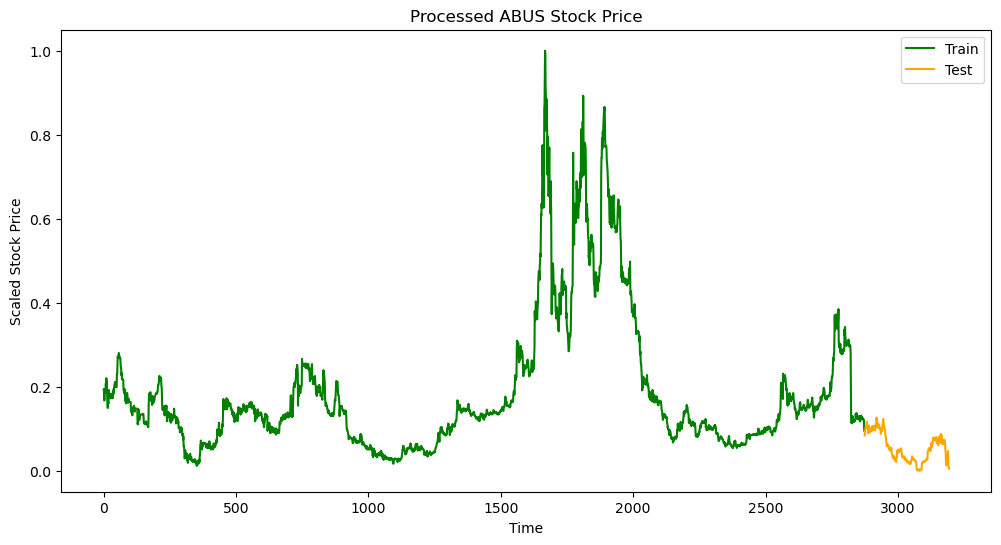

In [31]:
# visualize the main stock price
draw_data(train, test, title = "Processed ABUS Stock Price")

In [32]:
# generate input and output pairs for model training
(trainX, trainY), (testX, testY) = generate_pairs(train), generate_pairs(test)

In [33]:
trainX.shape

torch.Size([2854, 20, 1])

In [34]:
trainY.shape

torch.Size([2854, 1])

# 4. Model Building

## 4.1 Vanilla RNN

In [35]:
class RNN(nn.Module):
    def __init__(self, input_size = 1, layers = 2, hid_dim = 8, out_dim = 1):
        super(RNN,self).__init__()
        self.hid_dim=hid_dim
        self.layers=layers
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hid_dim, num_layers = layers)
        self.fc=nn.Linear(hid_dim, out_dim, bias=True)

    def forward(self, x):
        out, _=self.rnn(x, torch.zeros(self.layers, x.size(1), self.hid_dim))
        out = self.fc(out[:, -1])
        return out

## 4.2 LSTM

In [36]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, layers = 2, hid_dim = 8, out_dim = 1):
        super(LSTM, self).__init__()
        self.layers=layers
        self.hid_dim=hid_dim

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hid_dim, num_layers = layers)
        self.fc = nn.Linear(hid_dim, out_dim, bias=True)

    def forward(self, x):
        out, (_, _) = self.lstm(x, (torch.zeros(self.layers, x.size(1), self.hid_dim), torch.zeros(self.layers, x.size(1), self.hid_dim)))
        out=self.fc(out[:,-1])
        return out

## 4.3 GRU

In [37]:
class GRU(nn.Module):
    def __init__(self, input_size = 1, layers = 2, hid_dim = 8, out_dim = 1):
        super(GRU, self).__init__()
        self.layers = layers
        self.hid_dim = hid_dim
        self.gru = nn.GRU(input_size=input_size, hidden_size=hid_dim, num_layers = layers)
        self.fc = nn.Linear(hid_dim, out_dim, bias=True)

    def forward(self, x):
        out, (_, _) = self.gru(x, torch.zeros(self.layers, x.size(1), self.hid_dim))
        out = self.fc(out[:,-1])
        return out

## 4.4 Training Function

In [38]:
def train_model(model, trainX, trainY, valX, valY, learning_rate = 0.01, epochs = 50):
    criterion =  nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    train_rmse, val_rmse = [], []
    for i in range(epochs):
        
        # training process
        optimizer.zero_grad()
        out = model(trainX)
        loss = criterion(out, trainY)
        loss.backward()
        optimizer.step()
        train_rmse.append(np.sqrt(loss.item()))
        
        # validation
        vout = model(valX)
        vloss = criterion(vout, valY)
        val_rmse.append(np.sqrt(vloss.item()))
        
        if (i+1) % 5 == 0:
            print(f'epoch {i+1}, training rmse : {train_rmse[-1]:.4f}, val rmse : {val_rmse[-1]:.4f}')
            
    return train_rmse, val_rmse


### 4.4.1 Test RNN model

In [39]:
rnn_model = RNN()
train_rmse, test_rmse = train_model(rnn_model, trainX, trainY, testX, testY, learning_rate = 0.01)

epoch 5, training rmse : 0.2068, val rmse : 0.2389
epoch 10, training rmse : 0.1559, val rmse : 0.0446
epoch 15, training rmse : 0.1313, val rmse : 0.1218
epoch 20, training rmse : 0.1213, val rmse : 0.1106
epoch 25, training rmse : 0.0880, val rmse : 0.0188
epoch 30, training rmse : 0.0495, val rmse : 0.0692
epoch 35, training rmse : 0.0488, val rmse : 0.0228
epoch 40, training rmse : 0.0385, val rmse : 0.0204
epoch 45, training rmse : 0.0376, val rmse : 0.0267
epoch 50, training rmse : 0.0290, val rmse : 0.0210


RNN - Test RMSE:  0.021009487354653567


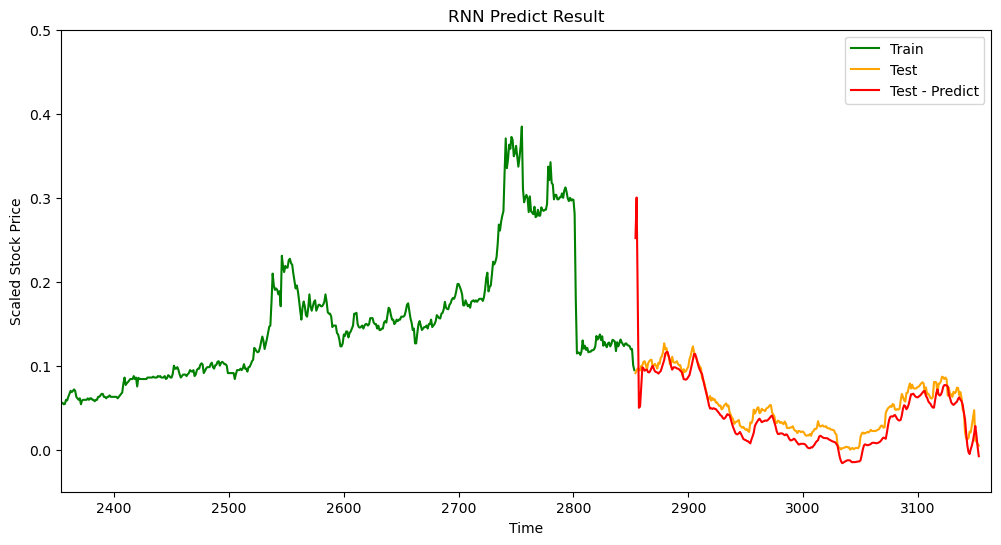

In [40]:
rnn_predict = test_model(rnn_model, testX, testY, split = "RNN - Test")
draw_data(trainY, testY, test_pred = rnn_predict, title = "RNN Predict Result")

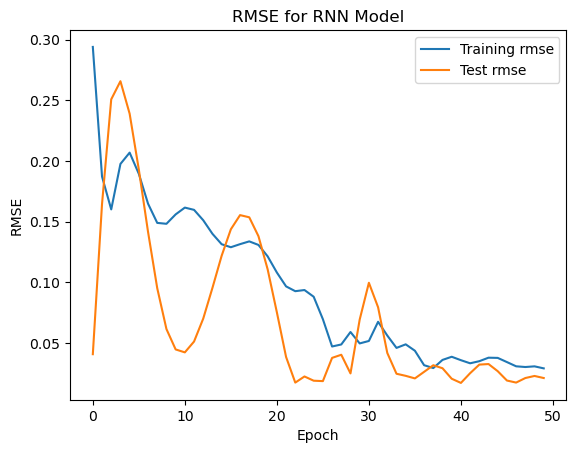

In [42]:
plt.plot(train_rmse, label = "Training rmse")
plt.plot(test_rmse, label = "Test rmse")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE for RNN Model")
plt.legend()
plt.show()

### 4.4.2 Test LSTM Model

In [43]:
lstm_model = LSTM()
train_rmse, test_rmse = train_model(lstm_model, trainX, trainY, testX, testY, learning_rate = 0.01)

epoch 5, training rmse : 0.1737, val rmse : 0.2285
epoch 10, training rmse : 0.1581, val rmse : 0.1200
epoch 15, training rmse : 0.1643, val rmse : 0.0866
epoch 20, training rmse : 0.1534, val rmse : 0.1375
epoch 25, training rmse : 0.1522, val rmse : 0.1515
epoch 30, training rmse : 0.1416, val rmse : 0.1017
epoch 35, training rmse : 0.1252, val rmse : 0.0961
epoch 40, training rmse : 0.0685, val rmse : 0.0376
epoch 45, training rmse : 0.0735, val rmse : 0.0260
epoch 50, training rmse : 0.0344, val rmse : 0.0415


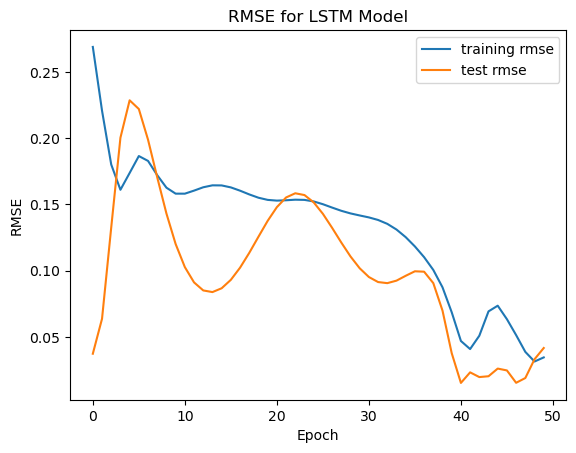

In [45]:
plt.plot(train_rmse, label = "training rmse")
plt.plot(test_rmse, label = "test rmse")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE for LSTM Model")
plt.legend()
plt.show()

LSTM - Test RMSE:  0.04154033464672358


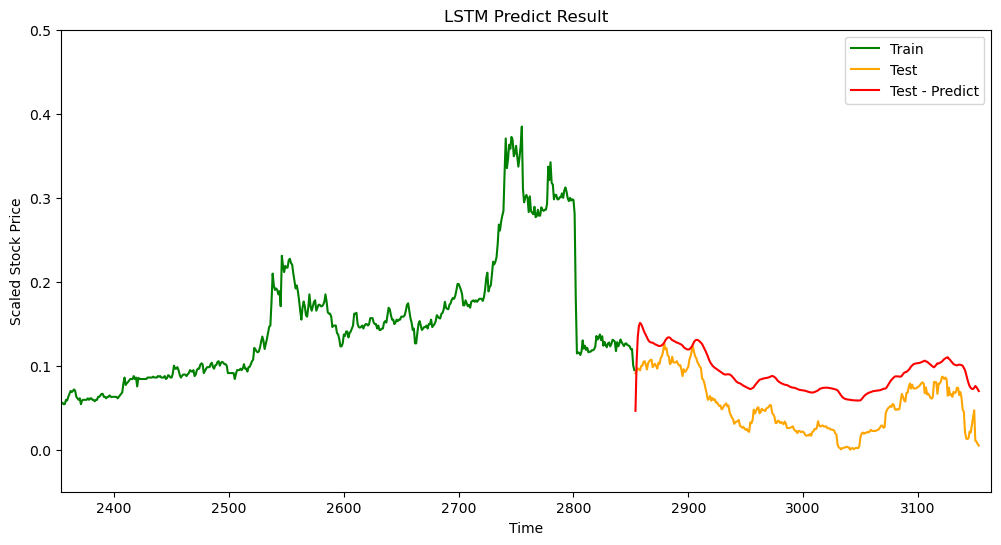

In [46]:
lstm_predict = test_model(lstm_model, testX, testY, split = "LSTM - Test")
draw_data(trainY, testY, test_pred = lstm_predict, title = "LSTM Predict Result")

### 4.4.3 Test GRU Model

In [47]:
gru_model = GRU()
train_rmse, test_rmse = train_model(gru_model, trainX, trainY, testX, testY, learning_rate = 0.01)

epoch 5, training rmse : 0.1614, val rmse : 0.0986
epoch 10, training rmse : 0.1968, val rmse : 0.0367
epoch 15, training rmse : 0.1643, val rmse : 0.0988
epoch 20, training rmse : 0.1559, val rmse : 0.1583
epoch 25, training rmse : 0.1580, val rmse : 0.1699
epoch 30, training rmse : 0.1489, val rmse : 0.1416
epoch 35, training rmse : 0.1381, val rmse : 0.1001
epoch 40, training rmse : 0.1220, val rmse : 0.0781
epoch 45, training rmse : 0.0843, val rmse : 0.0697
epoch 50, training rmse : 0.0431, val rmse : 0.0581


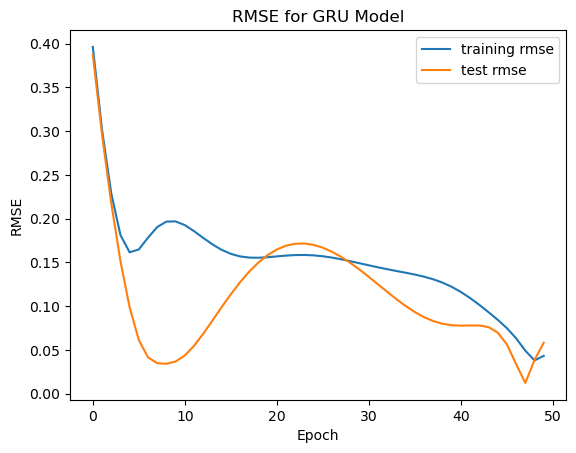

In [48]:
plt.plot(train_rmse, label = "training rmse")
plt.plot(test_rmse, label = "test rmse")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE for GRU Model")
plt.legend()
plt.show()

GRU - Test RMSE:  0.05813270018894444


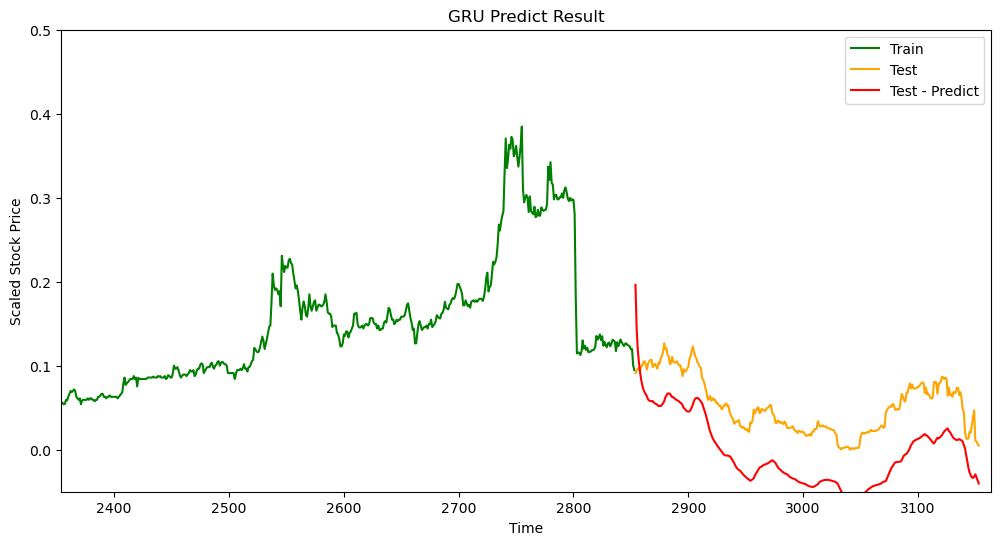

In [59]:
gru_predict = test_model(gru_model, testX, testY, split = "GRU - Test")
draw_data(trainY, testY, test_pred = gru_predict, title = "GRU Predict Result")

# 5. Experiments 

Since the RNN achieves the best RMSE in part 4, the following ablation study will mainly foucs on the RNN model.

## 5.1 Window Size Test

In [50]:
# generate pairs with 15 window size
(trainX_15, trainY_15), (testX_15, testY_15) = generate_pairs(train, window = 15), generate_pairs(test, window=15)

In [51]:
rnn_model_15 = RNN()
train_rmse, test_rmse = train_model(rnn_model_15, trainX_15, trainY_15, testX_15, testY_15, learning_rate = 0.01)

epoch 5, training rmse : 0.1570, val rmse : 0.2324
epoch 10, training rmse : 0.1772, val rmse : 0.1830
epoch 15, training rmse : 0.1684, val rmse : 0.0684
epoch 20, training rmse : 0.1606, val rmse : 0.1116
epoch 25, training rmse : 0.1576, val rmse : 0.1740
epoch 30, training rmse : 0.1509, val rmse : 0.1368
epoch 35, training rmse : 0.1475, val rmse : 0.0956
epoch 40, training rmse : 0.1383, val rmse : 0.1223
epoch 45, training rmse : 0.1301, val rmse : 0.1188
epoch 50, training rmse : 0.1145, val rmse : 0.0732


RNN - Test - Window size 15 -  RMSE:  0.07322739769701365


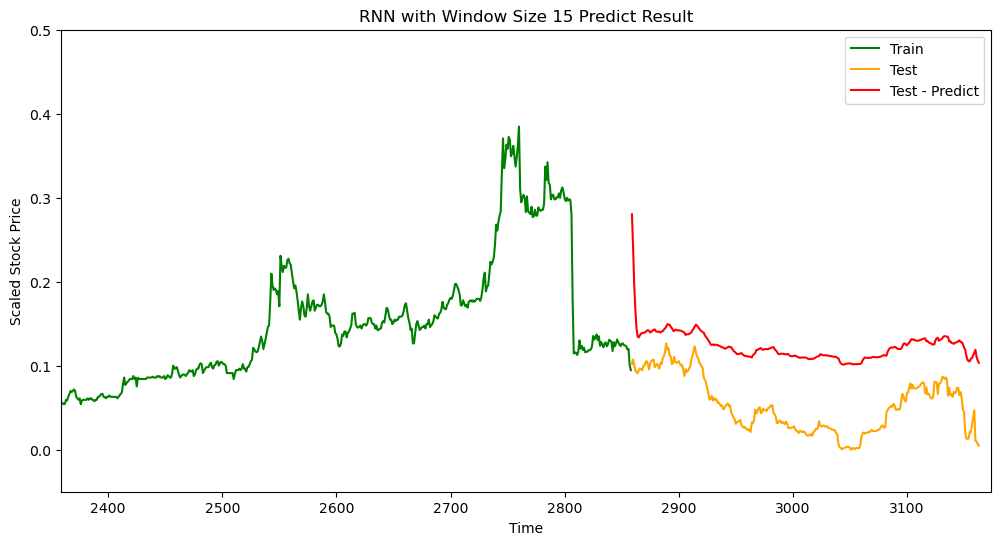

In [52]:
rnn_predict_15 = test_model(rnn_model_15, testX_15, testY_15, split = "RNN - Test - Window size 15 - ")
draw_data(trainY_15, testY_15, test_pred = rnn_predict_15, title = "RNN with Window Size 15 Predict Result")

In [53]:
# generate pairs with 25 window size
(trainX_25, trainY_25), (testX_25, testY_25) = generate_pairs(train, window = 25), generate_pairs(test, window=25)
rnn_model_25 = RNN()
train_rmse, test_rmse = train_model(rnn_model_25, trainX_25, trainY_25, testX_25, testY_25, learning_rate = 0.01)

epoch 5, training rmse : 0.1705, val rmse : 0.1720
epoch 10, training rmse : 0.1503, val rmse : 0.0785
epoch 15, training rmse : 0.1329, val rmse : 0.1356
epoch 20, training rmse : 0.1026, val rmse : 0.0598
epoch 25, training rmse : 0.0382, val rmse : 0.0251
epoch 30, training rmse : 0.0605, val rmse : 0.0345
epoch 35, training rmse : 0.0292, val rmse : 0.0086
epoch 40, training rmse : 0.0385, val rmse : 0.0245
epoch 45, training rmse : 0.0283, val rmse : 0.0147
epoch 50, training rmse : 0.0237, val rmse : 0.0238


RNN - Test - Window size 25 -  RMSE:  0.023792853691444148


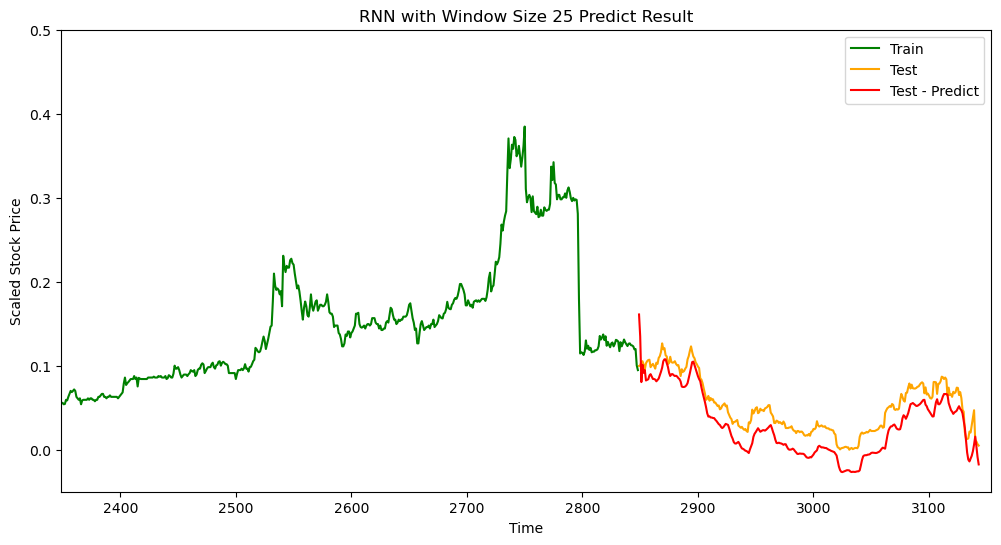

In [54]:
rnn_predict_25 = test_model(rnn_model_25, testX_25, testY_25, split = "RNN - Test - Window size 25 - ")
draw_data(trainY_25, testY_25, test_pred = rnn_predict_25, title = "RNN with Window Size 25 Predict Result")

## 5.2 Learning Rate Test 

In [55]:
# set learning rate 0.05
rnn_model_lr1 = RNN()
train_rmse, test_rmse = train_model(rnn_model_lr1, trainX, trainY, testX, testY, learning_rate = 0.05)

epoch 5, training rmse : 0.1770, val rmse : 0.1312
epoch 10, training rmse : 0.1612, val rmse : 0.1233
epoch 15, training rmse : 0.1514, val rmse : 0.1328
epoch 20, training rmse : 0.1293, val rmse : 0.0609
epoch 25, training rmse : 0.0839, val rmse : 0.0447
epoch 30, training rmse : 0.0790, val rmse : 0.1169
epoch 35, training rmse : 0.0476, val rmse : 0.0353
epoch 40, training rmse : 0.0427, val rmse : 0.0246
epoch 45, training rmse : 0.0293, val rmse : 0.0239
epoch 50, training rmse : 0.0282, val rmse : 0.0335


RNN - Test - Learning Rate 0.05 -  RMSE:  0.033537782231328576


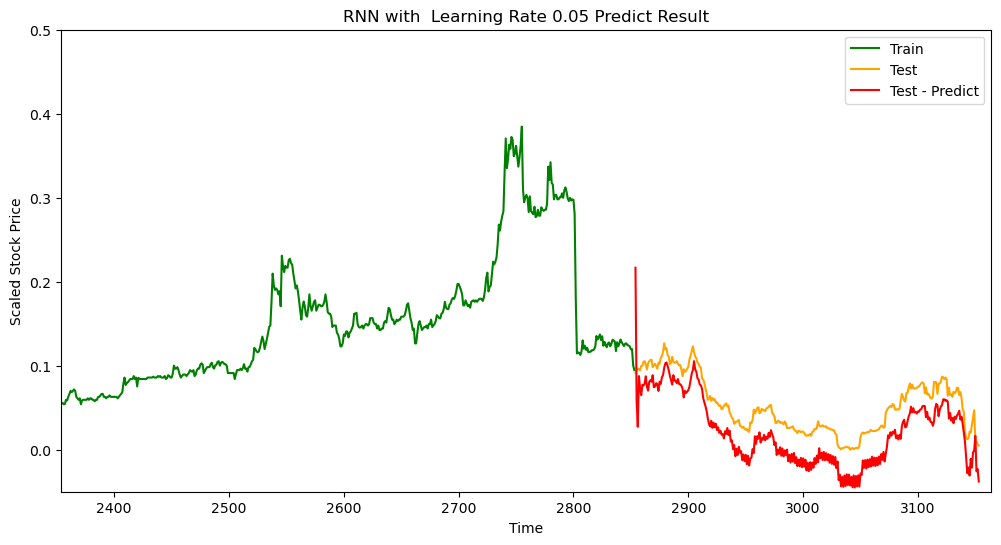

In [56]:
rnn_predict_lr1 = test_model(rnn_model_lr1, testX, testY, split = "RNN - Test - Learning Rate 0.05 - ")
draw_data(trainY, testY, test_pred = rnn_predict_lr1, title = "RNN with  Learning Rate 0.05 Predict Result")

In [57]:
# set learning rate 0.005
rnn_model_lr2 = RNN()
train_rmse, test_rmse = train_model(rnn_model_lr2, trainX, trainY, testX, testY, learning_rate = 0.005)

epoch 5, training rmse : 0.1473, val rmse : 0.1355
epoch 10, training rmse : 0.1225, val rmse : 0.0993
epoch 15, training rmse : 0.0761, val rmse : 0.0328
epoch 20, training rmse : 0.0399, val rmse : 0.0332
epoch 25, training rmse : 0.0472, val rmse : 0.0413
epoch 30, training rmse : 0.0300, val rmse : 0.0088
epoch 35, training rmse : 0.0381, val rmse : 0.0190
epoch 40, training rmse : 0.0285, val rmse : 0.0092
epoch 45, training rmse : 0.0269, val rmse : 0.0168
epoch 50, training rmse : 0.0267, val rmse : 0.0154


RNN - Test - Learning Rate 0.005 -  RMSE:  0.015385031134379923


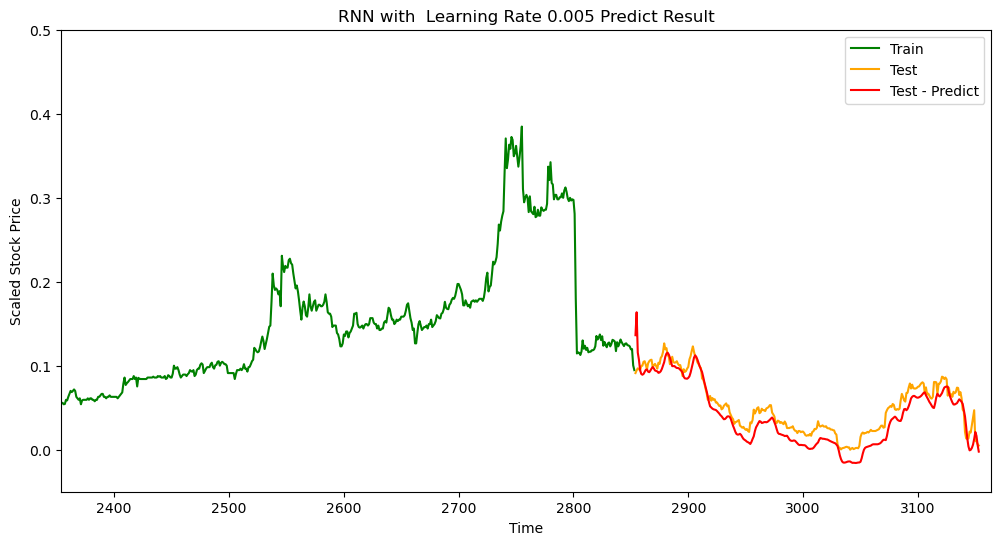

In [58]:
rnn_predict_lr2 = test_model(rnn_model_lr2, testX, testY, split = "RNN - Test - Learning Rate 0.005 - ")
draw_data(trainY, testY, test_pred = rnn_predict_lr2, title = "RNN with  Learning Rate 0.005 Predict Result")